## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
# Load and preprocess the data
Data = pd.read_excel("QBO Data.xlsx")
Data['Date'] = pd.to_datetime(Data['Date'], format='%d%m%Y')
Data.set_index('Date', inplace=True)

data_df = Data[['25 hPa']]  # Ini penting: index datetime tetap dipertahankan

In [4]:
print(data_df.columns)

Index(['25 hPa'], dtype='object')


In [5]:
Data.tail()

,30 hPa,25 hPa,20 hPa
Date,,,
2021-07-01,-238,-297,-316
2021-08-01,-233,-319,-330
2021-09-01,-268,-332,-359
2021-10-01,-283,-339,-368
2021-11-01,-279,-320,-351


In [6]:
def prepare_time_series_data(data, time_steps=28, test_size=0.3):
    """
    Prepare time series data for training and testing without shuffling to preserve time order.

    Parameters:
    - data: The time series data (n_samples, n_features).
    - time_steps: Number of time steps for each sample.
    - test_size: Proportion of data for testing (e.g., 0.3 = 30%).

    Returns:
    - X, y, x_train, x_test, y_train, y_test: Prepared datasets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    X = []
    y = []

    for i in range(time_steps, len(data_scaled)):
        X.append(data_scaled[i - time_steps:i, :])
        y.append(data_scaled[i, 0])  # Asumsi target adalah kolom pertama

    X = np.array(X)
    y = np.array(y)

    # Hitung split point untuk 70:30
    split_idx = int(len(X) * (1 - test_size))

    # Bagi data tanpa shuffle
    x_train, x_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X, y, x_train, x_test, y_train, y_test

# Contoh penggunaan:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps, test_size=0.3)

print("Training set shapes:")
print(x_train.shape, y_train.shape)  # Harusnya ~(293, 28, 20), (293,)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)    # Harusnya ~(126, 28, 20), (126,)

NameError: name 'extracted_features_data' is not defined

In [ ]:
print(f"Total samples after time_steps: {len(X)}")
print(f"Training: {len(x_train)} samples ({len(x_train)/len(X)*100:.1f}%)")
print(f"Testing:  {len(x_test)} samples ({len(x_test)/len(X)*100:.1f}%)")

Total samples after time_steps: 325
Training: 227 samples (69.8%)
Testing:  98 samples (30.2%)


In [ ]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - loss: 1.1554 - mae: 1.0254 - r_squared: -66.2300
Epoch 1: val_loss improved from inf to 0.73771, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 432ms/step - loss: 1.0791 - mae: 0.9857 - r_squared: -59.7936 - val_loss: 0.7377 - val_mae: 0.8013 - val_r_squared: -35.9494
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7949 - mae: 0.8414 - r_squared: -66.1556
Epoch 2: val_loss improved from 0.73771 to 0.56217, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.7794 - mae: 0.8299 - r_squared: -61.1823 - val_loss: 0.5622 - val_mae: 0.6799 - val_r_squared: -39.0314
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.5985 - mae: 0.7222 - r_squared: -72.9381
Epoch 3: val_loss improved from 0.56217 to 0.41849, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.5829 - mae: 0.6951 - r_squared: -68.7695 - val_loss: 0.4185 - val_mae: 0.5415 - val_r_squared: -44.3622
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4258 - mae: 0.5566 - r_squared: -85.2254
Epoch 4: val_loss improved from 0.41849 to 0.31257, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.4208 - mae: 0.5418 - r_squared: -79.2195 - val_loss: 0.3126 - val_mae: 0.4280 - val_r_squared: -51.5075
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3706 - mae: 0.4544 - r_squared: -103.5189
Epoch 5: val_loss improved from 0.31257 to 0.28518, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.3193 - mae: 0.4140 - r_squared: -95.9163 - val_loss: 0.2852 - val_mae: 0.3831 - val_r_squared: -59.8491
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2902 - mae: 0.3970 - r_squared: -122.3772
Epoch 6: val_loss improved from 0.28518 to 0.26415, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2508 - mae: 0.3783 - r_squared: -111.0099 - val_loss: 0.2641 - val_mae: 0.3849 - val_r_squared: -59.2888
Epoch 7/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2042 - mae: 0.3654 - r_squared: -127.5648
Epoch 7: val_loss improved from 0.26415 to 0.25361, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1976 - mae: 0.3502 - r_squared: -111.4132 - val_loss: 0.2536 - val_mae: 0.3937 - val_r_squared: -55.4383
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1427 - mae: 0.2861 - r_squared: -125.9133
Epoch 8: val_loss improved from 0.25361 to 0.23002, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1776 - mae: 0.3160 - r_squared: -106.8243 - val_loss: 0.2300 - val_mae: 0.3794 - val_r_squared: -54.8372
Epoch 9/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1555 - mae: 0.2969 - r_squared: -113.8134
Epoch 9: val_loss improved from 0.23002 to 0.19395, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1515 - mae: 0.2903 - r_squared: -105.0168 - val_loss: 0.1940 - val_mae: 0.3357 - val_r_squared: -57.5593
Epoch 10/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1010 - mae: 0.2390 - r_squared: -121.2097
Epoch 10: val_loss improved from 0.19395 to 0.19033, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1265 - mae: 0.2559 - r_squared: -108.8839 - val_loss: 0.1903 - val_mae: 0.3212 - val_r_squared: -61.0206
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1389 - mae: 0.2551 - r_squared: -121.6182
Epoch 11: val_loss improved from 0.19033 to 0.18706, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1322 - mae: 0.2562 - r_squared: -113.0441 - val_loss: 0.1871 - val_mae: 0.3235 - val_r_squared: -61.4507
Epoch 12/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1053 - mae: 0.2371 - r_squared: -122.6723
Epoch 12: val_loss improved from 0.18706 to 0.18098, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1213 - mae: 0.2508 - r_squared: -111.6099 - val_loss: 0.1810 - val_mae: 0.3331 - val_r_squared: -59.1072
Epoch 13/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0811 - mae: 0.2174 - r_squared: -128.4633
Epoch 13: val_loss improved from 0.18098 to 0.18058, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1099 - mae: 0.2468 - r_squared: -108.9128 - val_loss: 0.1806 - val_mae: 0.3340 - val_r_squared: -57.3685
Epoch 14/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1124 - mae: 0.2556 - r_squared: -112.7051
Epoch 14: val_loss improved from 0.18058 to 0.17518, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1150 - mae: 0.2519 - r_squared: -103.0542 - val_loss: 0.1752 - val_mae: 0.3192 - val_r_squared: -58.4509
Epoch 15/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1254 - mae: 0.2542 - r_squared: -115.6579
Epoch 15: val_loss improved from 0.17518 to 0.16945, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1132 - mae: 0.2412 - r_squared: -105.8822 - val_loss: 0.1695 - val_mae: 0.3083 - val_r_squared: -60.2645
Epoch 16/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1392 - mae: 0.2612 - r_squared: -114.2384
Epoch 16: val_loss improved from 0.16945 to 0.16212, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1101 - mae: 0.2347 - r_squared: -107.2657 - val_loss: 0.1621 - val_mae: 0.3021 - val_r_squared: -61.6083
Epoch 17/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0947 - mae: 0.2278 - r_squared: -118.5974
Epoch 17: val_loss improved from 0.16212 to 0.15893, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0974 - mae: 0.2267 - r_squared: -111.2107 - val_loss: 0.1589 - val_mae: 0.2940 - val_r_squared: -62.4866
Epoch 18/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0646 - mae: 0.1853 - r_squared: -127.1679
Epoch 18: val_loss improved from 0.15893 to 0.15736, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0851 - mae: 0.2071 - r_squared: -113.5015 - val_loss: 0.1574 - val_mae: 0.2901 - val_r_squared: -61.2812
Epoch 19/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1103 - mae: 0.2335 - r_squared: -115.7097
Epoch 19: val_loss improved from 0.15736 to 0.15704, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0964 - mae: 0.2198 - r_squared: -108.7483 - val_loss: 0.1570 - val_mae: 0.2883 - val_r_squared: -60.6939
Epoch 20/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0986 - mae: 0.2154 - r_squared: -116.5649
Epoch 20: val_loss improved from 0.15704 to 0.15597, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0927 - mae: 0.2154 - r_squared: -108.1190 - val_loss: 0.1560 - val_mae: 0.2860 - val_r_squared: -60.7805
Epoch 21/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0882 - mae: 0.2146 - r_squared: -121.4664
Epoch 21: val_loss improved from 0.15597 to 0.15112, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0846 - mae: 0.2094 - r_squared: -109.6806 - val_loss: 0.1511 - val_mae: 0.2847 - val_r_squared: -60.8439
Epoch 22/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0797 - mae: 0.2039 - r_squared: -120.6291
Epoch 22: val_loss improved from 0.15112 to 0.15036, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0817 - mae: 0.2054 - r_squared: -109.5799 - val_loss: 0.1504 - val_mae: 0.2827 - val_r_squared: -61.3305
Epoch 23/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0760 - mae: 0.2003 - r_squared: -120.1820
Epoch 23: val_loss improved from 0.15036 to 0.14932, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0795 - mae: 0.2052 - r_squared: -110.0344 - val_loss: 0.1493 - val_mae: 0.2805 - val_r_squared: -61.2598
Epoch 24/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0701 - mae: 0.1942 - r_squared: -121.7215
Epoch 24: val_loss improved from 0.14932 to 0.14854, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0758 - mae: 0.2012 - r_squared: -110.0326 - val_loss: 0.1485 - val_mae: 0.2787 - val_r_squared: -61.2361
Epoch 25/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0651 - mae: 0.1865 - r_squared: -119.7252
Epoch 25: val_loss did not improve from 0.14854
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0734 - mae: 0.1974 - r_squared: -109.7236 - val_loss: 0.1489 - val_mae: 0.2749 - val_r_squared: -62.4935
Epoch 26/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0624 - mae: 0.1804 - r_squared: -123.4914
Epoch 26: val_loss improved from 0.14854 to 0.14695, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0709 - mae: 0.1907 - r_squared: -112.4316 - val_loss: 0.1470 - val_mae: 0.2708 - val_r_squared: -62.6527
Epoch 27/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0891 - mae: 0.2193 - r_squared: -125.9412
Epoch 27: val_loss improved from 0.14695 to 0.14451, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0790 - mae: 0.2029 - r_squared: -111.9879 - val_loss: 0.1445 - val_mae: 0.2728 - val_r_squared: -61.6151
Epoch 28/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0439 - mae: 0.1636 - r_squared: -124.5319
Epoch 28: val_loss improved from 0.14451 to 0.14369, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0629 - mae: 0.1871 - r_squared: -111.5594 - val_loss: 0.1437 - val_mae: 0.2725 - val_r_squared: -61.5360
Epoch 29/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0756 - mae: 0.2041 - r_squared: -117.8677
Epoch 29: val_loss improved from 0.14369 to 0.14232, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0738 - mae: 0.2025 - r_squared: -109.6739 - val_loss: 0.1423 - val_mae: 0.2706 - val_r_squared: -62.2186
Epoch 30/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0675 - mae: 0.2025 - r_squared: -123.0098
Epoch 30: val_loss improved from 0.14232 to 0.14171, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0683 - mae: 0.1970 - r_squared: -111.6233 - val_loss: 0.1417 - val_mae: 0.2656 - val_r_squared: -62.2916
Epoch 31/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0453 - mae: 0.1679 - r_squared: -126.1050
Epoch 31: val_loss improved from 0.14171 to 0.13881, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0610 - mae: 0.1842 - r_squared: -112.4221 - val_loss: 0.1388 - val_mae: 0.2599 - val_r_squared: -62.2891
Epoch 32/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0684 - mae: 0.2035 - r_squared: -122.4668
Epoch 32: val_loss improved from 0.13881 to 0.13594, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0680 - mae: 0.1946 - r_squared: -111.4770 - val_loss: 0.1359 - val_mae: 0.2546 - val_r_squared: -62.7448
Epoch 33/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0678 - mae: 0.1912 - r_squared: -124.7139
Epoch 33: val_loss improved from 0.13594 to 0.13389, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0647 - mae: 0.1872 - r_squared: -111.6514 - val_loss: 0.1339 - val_mae: 0.2567 - val_r_squared: -61.9091
Epoch 34/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0758 - mae: 0.2032 - r_squared: -120.6839
Epoch 34: val_loss improved from 0.13389 to 0.13158, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0710 - mae: 0.2011 - r_squared: -110.1216 - val_loss: 0.1316 - val_mae: 0.2553 - val_r_squared: -62.0333
Epoch 35/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0561 - mae: 0.1773 - r_squared: -120.2791
Epoch 35: val_loss did not improve from 0.13158
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0612 - mae: 0.1858 - r_squared: -111.3786 - val_loss: 0.1379 - val_mae: 0.2533 - val_r_squared: -63.2690
Epoch 36/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0342 - mae: 0.1429 - r_squared: -123.4781
Epoch 36: val_loss did not improve from 0.13158
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0590 - mae: 0.1766 - r_squared: -113.2217 - val_loss: 0.1322 - val_mae: 0.2522 - val_r_squared: -61.1722
Epoch 37/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0635 - mae: 0.1930 - r_squared: -122.9833
Epoch 37: val_loss did not improve from 0.13158
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0634 - mae: 0.1926 - r_squared: -109.95

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0600 - mae: 0.1787 - r_squared: -115.7160 - val_loss: 0.1272 - val_mae: 0.2484 - val_r_squared: -62.3310
Epoch 41/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0702 - mae: 0.2072 - r_squared: -119.3106
Epoch 41: val_loss improved from 0.12719 to 0.12477, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0614 - mae: 0.1915 - r_squared: -110.7985 - val_loss: 0.1248 - val_mae: 0.2437 - val_r_squared: -62.1260
Epoch 42/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0546 - mae: 0.1818 - r_squared: -122.7930
Epoch 42: val_loss did not improve from 0.12477
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0593 - mae: 0.1834 - r_squared: -112.0842 - val_loss: 0.1304 - val_mae: 0.2488 - val_r_squared: -62.2380
Epoch 43/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0378 - mae: 0.1546 - r_squared: -122.5748
Epoch 43: val_loss did not improve from 0.12477
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0519 - mae: 0.1733 - r_squared: -111.9538 - val_loss: 0.1274 - val_mae: 0.2469 - val_r_squared: -61.6783
Epoch 44/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0457 - mae: 0.1734 - r_squared: -120.1790
Epoch 44: val_loss did not improve from 0.12477
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0535 - mae: 0.1818 - r_squared: -110.34

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - loss: 0.0520 - mae: 0.1703 - r_squared: -112.9579 - val_loss: 0.1229 - val_mae: 0.2387 - val_r_squared: -62.3850
Epoch 48/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0628 - mae: 0.1932 - r_squared: -123.4207
Epoch 48: val_loss improved from 0.12289 to 0.12171, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0564 - mae: 0.1827 - r_squared: -111.2810 - val_loss: 0.1217 - val_mae: 0.2383 - val_r_squared: -62.8303
Epoch 49/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0543 - mae: 0.1843 - r_squared: -121.7307
Epoch 49: val_loss did not improve from 0.12171
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0521 - mae: 0.1758 - r_squared: -112.6263 - val_loss: 0.1251 - val_mae: 0.2459 - val_r_squared: -64.6992
Epoch 50/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0365 - mae: 0.1457 - r_squared: -125.2405
Epoch 50: val_loss did not improve from 0.12171
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0501 - mae: 0.1665 - r_squared: -114.4954 - val_loss: 0.1238 - val_mae: 0.2411 - val_r_squared: -62.1456
Epoch 51/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0493 - mae: 0.1731 - r_squared: -124.0831
Epoch 51: val_loss did not improve from 0.12171
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0515 - mae: 0.1752 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.0516 - mae: 0.1680 - r_squared: -112.9844 - val_loss: 0.1214 - val_mae: 0.2399 - val_r_squared: -63.6939
Epoch 54/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0487 - mae: 0.1736 - r_squared: -122.4684
Epoch 54: val_loss did not improve from 0.12145
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0509 - mae: 0.1708 - r_squared: -112.9072 - val_loss: 0.1230 - val_mae: 0.2400 - val_r_squared: -62.7533
Epoch 55/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0501 - mae: 0.1682 - r_squared: -114.9080 
Epoch 55: val_loss improved from 0.12145 to 0.12092, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - loss: 0.0500 - mae: 0.1687 - r_squared: -111.2431 - val_loss: 0.1209 - val_mae: 0.2341 - val_r_squared: -61.7343
Epoch 56/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0603 - mae: 0.1964 - r_squared: -123.0674
Epoch 56: val_loss improved from 0.12092 to 0.11957, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.0516 - mae: 0.1767 - r_squared: -111.2285 - val_loss: 0.1196 - val_mae: 0.2385 - val_r_squared: -64.6836
Epoch 57/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0581 - mae: 0.1854 - r_squared: -122.7408
Epoch 57: val_loss did not improve from 0.11957
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0527 - mae: 0.1719 - r_squared: -115.4815 - val_loss: 0.1214 - val_mae: 0.2462 - val_r_squared: -66.4659
Epoch 58/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0558 - mae: 0.1811 - r_squared: -127.8398
Epoch 58: val_loss improved from 0.11957 to 0.11780, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0524 - mae: 0.1719 - r_squared: -116.6476 - val_loss: 0.1178 - val_mae: 0.2330 - val_r_squared: -63.5719
Epoch 59/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0490 - mae: 0.1598 - r_squared: -121.7334
Epoch 59: val_loss did not improve from 0.11780
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0476 - mae: 0.1623 - r_squared: -111.4616 - val_loss: 0.1224 - val_mae: 0.2412 - val_r_squared: -62.9752
Epoch 60/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0430 - mae: 0.1517 - r_squared: -121.1798
Epoch 60: val_loss did not improve from 0.11780
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0462 - mae: 0.1601 - r_squared: -110.9184 - val_loss: 0.1208 - val_mae: 0.2400 - val_r_squared: -64.0302
Epoch 61/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0461 - mae: 0.1603 - r_squared: -124.9994
Epoch 61: val_loss did not improve from 0.11780
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0439 - mae: 0.1554 - r_squared: -11

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0445 - mae: 0.1521 - r_squared: -114.4270 - val_loss: 0.1173 - val_mae: 0.2334 - val_r_squared: -63.4301
Epoch 65/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0383 - mae: 0.1478 - r_squared: -124.9491
Epoch 65: val_loss improved from 0.11727 to 0.11702, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0444 - mae: 0.1568 - r_squared: -111.6989 - val_loss: 0.1170 - val_mae: 0.2317 - val_r_squared: -63.5891
Epoch 66/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0378 - mae: 0.1491 - r_squared: -122.6686
Epoch 66: val_loss did not improve from 0.11702
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0402 - mae: 0.1503 - r_squared: -113.1501 - val_loss: 0.1228 - val_mae: 0.2452 - val_r_squared: -65.4552
Epoch 67/200


In [ ]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.1567 - mae: 0.9453 - r_squared: -71.4425
Epoch 1: val_loss improved from inf to 0.59296, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 1.1464 - mae: 0.9427 - r_squared: -69.0225 - val_loss: 0.5930 - val_mae: 0.7294 - val_r_squared: -38.7196
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.7027 - mae: 0.7394 - r_squared: -77.4858 
Epoch 2: val_loss improved from 0.59296 to 0.44799, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - loss: 0.7002 - mae: 0.7371 - r_squared: -75.1693 - val_loss: 0.4480 - val_mae: 0.5454 - val_r_squared: -50.3374
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.4795 - mae: 0.5623 - r_squared: -84.5375 
Epoch 3: val_loss improved from 0.44799 to 0.39898, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step - loss: 0.4686 - mae: 0.5512 - r_squared: -82.8571 - val_loss: 0.3990 - val_mae: 0.4450 - val_r_squared: -63.3052
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.4827 - mae: 0.5237 - r_squared: -109.4753 
Epoch 4: val_loss improved from 0.39898 to 0.35279, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - loss: 0.4791 - mae: 0.5213 - r_squared: -106.7876 - val_loss: 0.3528 - val_mae: 0.4420 - val_r_squared: -66.6914
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.3411 - mae: 0.4483 - r_squared: -117.2302 
Epoch 5: val_loss improved from 0.35279 to 0.33012, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - loss: 0.3477 - mae: 0.4529 - r_squared: -112.4078 - val_loss: 0.3301 - val_mae: 0.4513 - val_r_squared: -63.1534
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3564 - mae: 0.4685 - r_squared: -107.0622
Epoch 6: val_loss improved from 0.33012 to 0.28561, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - loss: 0.3573 - mae: 0.4691 - r_squared: -103.0872 - val_loss: 0.2856 - val_mae: 0.3957 - val_r_squared: -60.7049
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2977 - mae: 0.4112 - r_squared: -106.1287
Epoch 7: val_loss improved from 0.28561 to 0.28181, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - loss: 0.2999 - mae: 0.4107 - r_squared: -102.3926 - val_loss: 0.2818 - val_mae: 0.3866 - val_r_squared: -60.1589
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2904 - mae: 0.4123 - r_squared: -98.2976  
Epoch 8: val_loss improved from 0.28181 to 0.27114, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 0.2905 - mae: 0.4135 - r_squared: -95.5961 - val_loss: 0.2711 - val_mae: 0.3956 - val_r_squared: -57.8614
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2586 - mae: 0.3708 - r_squared: -97.9489  
Epoch 9: val_loss improved from 0.27114 to 0.26459, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step - loss: 0.2615 - mae: 0.3740 - r_squared: -94.7093 - val_loss: 0.2646 - val_mae: 0.4003 - val_r_squared: -55.9417
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2644 - mae: 0.4091 - r_squared: -96.7561 
Epoch 10: val_loss improved from 0.26459 to 0.24699, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - loss: 0.2644 - mae: 0.4092 - r_squared: -93.3760 - val_loss: 0.2470 - val_mae: 0.3814 - val_r_squared: -58.4204
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2941 - mae: 0.4089 - r_squared: -97.4117  
Epoch 11: val_loss improved from 0.24699 to 0.23663, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step - loss: 0.2843 - mae: 0.4035 - r_squared: -95.0632 - val_loss: 0.2366 - val_mae: 0.3686 - val_r_squared: -62.8769
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2532 - mae: 0.3853 - r_squared: -108.6097 
Epoch 12: val_loss improved from 0.23663 to 0.22995, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step - loss: 0.2507 - mae: 0.3820 - r_squared: -105.1640 - val_loss: 0.2299 - val_mae: 0.3591 - val_r_squared: -65.3537
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2340 - mae: 0.3761 - r_squared: -113.3367
Epoch 13: val_loss improved from 0.22995 to 0.22110, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - loss: 0.2364 - mae: 0.3765 - r_squared: -109.9009 - val_loss: 0.2211 - val_mae: 0.3512 - val_r_squared: -64.4861
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2666 - mae: 0.3778 - r_squared: -115.9588
Epoch 14: val_loss improved from 0.22110 to 0.21643, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 0.2644 - mae: 0.3762 - r_squared: -111.9387 - val_loss: 0.2164 - val_mae: 0.3452 - val_r_squared: -64.1682
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2568 - mae: 0.3778 - r_squared: -110.9999 
Epoch 15: val_loss improved from 0.21643 to 0.21455, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - loss: 0.2500 - mae: 0.3741 - r_squared: -107.6277 - val_loss: 0.2145 - val_mae: 0.3462 - val_r_squared: -63.2858
Epoch 16/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2364 - mae: 0.3708 - r_squared: -109.3236 
Epoch 16: val_loss did not improve from 0.21455
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.2358 - mae: 0.3694 - r_squared: -105.5257 - val_loss: 0.2149 - val_mae: 0.3453 - val_r_squared: -62.3185
Epoch 17/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2091 - mae: 0.3392 - r_squared: -101.6956
Epoch 17: val_loss improved from 0.21455 to 0.20569, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - loss: 0.2078 - mae: 0.3391 - r_squared: -98.4278 - val_loss: 0.2057 - val_mae: 0.3352 - val_r_squared: -61.1967
Epoch 18/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1879 - mae: 0.3304 - r_squared: -105.0625 
Epoch 18: val_loss improved from 0.20569 to 0.19984, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - loss: 0.1888 - mae: 0.3312 - r_squared: -101.7149 - val_loss: 0.1998 - val_mae: 0.3279 - val_r_squared: -62.9953
Epoch 19/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2071 - mae: 0.3301 - r_squared: -110.4193 
Epoch 19: val_loss improved from 0.19984 to 0.19340, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step - loss: 0.2085 - mae: 0.3314 - r_squared: -106.8062 - val_loss: 0.1934 - val_mae: 0.3253 - val_r_squared: -65.0941
Epoch 20/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1730 - mae: 0.3097 - r_squared: -111.4427 
Epoch 20: val_loss improved from 0.19340 to 0.18867, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step - loss: 0.1740 - mae: 0.3107 - r_squared: -107.6865 - val_loss: 0.1887 - val_mae: 0.3253 - val_r_squared: -65.6452
Epoch 21/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2067 - mae: 0.3342 - r_squared: -115.0132 
Epoch 21: val_loss improved from 0.18867 to 0.18801, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - loss: 0.2029 - mae: 0.3303 - r_squared: -111.6889 - val_loss: 0.1880 - val_mae: 0.3255 - val_r_squared: -65.4077
Epoch 22/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1711 - mae: 0.3015 - r_squared: -112.7033 
Epoch 22: val_loss did not improve from 0.18801
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.1734 - mae: 0.3045 - r_squared: -109.0860 - val_loss: 0.1945 - val_mae: 0.3297 - val_r_squared: -65.7615
Epoch 23/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1827 - mae: 0.3171 - r_squared: -109.2628
Epoch 23: val_loss did not improve from 0.18801
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.1837 - mae: 0.3181 - r_squared: -105.9953 - val_loss: 0.1996 - val_mae: 0.3347 - val_r_squared: -66.4175
Epoch 24/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2134 - mae: 0.3464 - r_squared: -109.4121 
Epoch 24: val_loss improved from 0.18801 to 0.17997, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - loss: 0.2063 - mae: 0.3410 - r_squared: -106.2256 - val_loss: 0.1800 - val_mae: 0.3179 - val_r_squared: -64.3999
Epoch 25/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1486 - mae: 0.2994 - r_squared: -109.7071 
Epoch 25: val_loss improved from 0.17997 to 0.17265, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step - loss: 0.1491 - mae: 0.2985 - r_squared: -106.3559 - val_loss: 0.1726 - val_mae: 0.3103 - val_r_squared: -65.0663
Epoch 26/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1805 - mae: 0.2996 - r_squared: -111.1367
Epoch 26: val_loss did not improve from 0.17265
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.1755 - mae: 0.2967 - r_squared: -107.4526 - val_loss: 0.1776 - val_mae: 0.3133 - val_r_squared: -67.3763
Epoch 27/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1394 - mae: 0.2798 - r_squared: -116.9104 
Epoch 27: val_loss did not improve from 0.17265
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.1420 - mae: 0.2822 - r_squared: -113.3072 - val_loss: 0.1763 - val_mae: 0.3083 - val_r_squared: -66.8445
Epoch 28/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1628 - mae: 0.3024 - r_squared: -111.4999
Epoch 28: val_loss improved from 0.17265 to 0.15842, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.1570 - mae: 0.2969 - r_squared: -107.9841 - val_loss: 0.1584 - val_mae: 0.2912 - val_r_squared: -62.1745
Epoch 29/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1463 - mae: 0.2774 - r_squared: -109.6530
Epoch 29: val_loss improved from 0.15842 to 0.15296, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - loss: 0.1458 - mae: 0.2781 - r_squared: -106.0352 - val_loss: 0.1530 - val_mae: 0.2865 - val_r_squared: -62.5679
Epoch 30/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1173 - mae: 0.2532 - r_squared: -107.6921 
Epoch 30: val_loss did not improve from 0.15296
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.1209 - mae: 0.2564 - r_squared: -104.5401 - val_loss: 0.1580 - val_mae: 0.2966 - val_r_squared: -66.5830
Epoch 31/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1510 - mae: 0.2815 - r_squared: -112.8995
Epoch 31: val_loss improved from 0.15296 to 0.14980, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step - loss: 0.1494 - mae: 0.2814 - r_squared: -109.4613 - val_loss: 0.1498 - val_mae: 0.2930 - val_r_squared: -65.9948
Epoch 32/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1584 - mae: 0.2918 - r_squared: -117.6846 
Epoch 32: val_loss improved from 0.14980 to 0.14526, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 0.1549 - mae: 0.2901 - r_squared: -113.1898 - val_loss: 0.1453 - val_mae: 0.2815 - val_r_squared: -63.9234
Epoch 33/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1101 - mae: 0.2492 - r_squared: -111.7877 
Epoch 33: val_loss did not improve from 0.14526
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.1131 - mae: 0.2521 - r_squared: -108.4358 - val_loss: 0.1529 - val_mae: 0.2810 - val_r_squared: -64.1805
Epoch 34/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1125 - mae: 0.2561 - r_squared: -112.9357 
Epoch 34: val_loss did not improve from 0.14526
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.1135 - mae: 0.2576 - r_squared: -109.7575 - val_loss: 0.1590 - val_mae: 0.2847 - val_r_squared: -63.9515
Epoch 35/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1119 - mae: 0.2620 - r_squared: -109.3275 
Epoch 35: val_loss improved from 0.14526 to 0.14286, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - loss: 0.1134 - mae: 0.2626 - r_squared: -106.1254 - val_loss: 0.1429 - val_mae: 0.2752 - val_r_squared: -62.7907
Epoch 36/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1087 - mae: 0.2499 - r_squared: -111.5655 
Epoch 36: val_loss improved from 0.14286 to 0.13678, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 0.1124 - mae: 0.2534 - r_squared: -108.2589 - val_loss: 0.1368 - val_mae: 0.2734 - val_r_squared: -64.4541
Epoch 37/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1279 - mae: 0.2698 - r_squared: -108.3549 
Epoch 37: val_loss did not improve from 0.13678
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.1265 - mae: 0.2693 - r_squared: -105.0372 - val_loss: 0.1497 - val_mae: 0.2992 - val_r_squared: -69.5222
Epoch 38/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0961 - mae: 0.2451 - r_squared: -120.7765 
Epoch 38: val_loss did not improve from 0.13678
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0977 - mae: 0.2472 - r_squared: -117.2055 - val_loss: 0.1463 - val_mae: 0.2899 - val_r_squared: -68.8907
Epoch 39/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0949 - mae: 0.2391 - r_squared: -119.3097 
Epoch 39: val_loss improved from 0.13678 to 0.13278, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step - loss: 0.0967 - mae: 0.2394 - r_squared: -115.1273 - val_loss: 0.1328 - val_mae: 0.2670 - val_r_squared: -63.5388
Epoch 40/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1147 - mae: 0.2518 - r_squared: -111.9208
Epoch 40: val_loss did not improve from 0.13278
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.1152 - mae: 0.2498 - r_squared: -108.5699 - val_loss: 0.1357 - val_mae: 0.2722 - val_r_squared: -63.1081
Epoch 41/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1177 - mae: 0.2606 - r_squared: -110.4199
Epoch 41: val_loss did not improve from 0.13278
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.1207 - mae: 0.2650 - r_squared: -106.5386 - val_loss: 0.1440 - val_mae: 0.2820 - val_r_squared: -65.7990
Epoch 42/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0869 - mae: 0.2353 - r_squared: -112.7344 
Epoch 42: val_loss did not improve from 0.13278
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0889 - mae: 0.2360 - r_squared: -

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - loss: 0.0975 - mae: 0.2331 - r_squared: -110.7022 - val_loss: 0.1315 - val_mae: 0.2730 - val_r_squared: -65.6050
Epoch 45/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0971 - mae: 0.2386 - r_squared: -115.3603
Epoch 45: val_loss improved from 0.13151 to 0.13024, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 713ms/step - loss: 0.0950 - mae: 0.2355 - r_squared: -111.3374 - val_loss: 0.1302 - val_mae: 0.2694 - val_r_squared: -65.4271
Epoch 46/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0983 - mae: 0.2425 - r_squared: -115.6597
Epoch 46: val_loss did not improve from 0.13024
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - loss: 0.0987 - mae: 0.2428 - r_squared: -111.8835 - val_loss: 0.1306 - val_mae: 0.2674 - val_r_squared: -66.9312
Epoch 47/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0959 - mae: 0.2467 - r_squared: -113.8314
Epoch 47: val_loss improved from 0.13024 to 0.11657, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 716ms/step - loss: 0.0952 - mae: 0.2438 - r_squared: -110.3164 - val_loss: 0.1166 - val_mae: 0.2593 - val_r_squared: -66.8852
Epoch 48/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0863 - mae: 0.2302 - r_squared: -114.7442
Epoch 48: val_loss did not improve from 0.11657
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.0858 - mae: 0.2290 - r_squared: -111.5080 - val_loss: 0.1193 - val_mae: 0.2613 - val_r_squared: -68.2596
Epoch 49/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0808 - mae: 0.2294 - r_squared: -120.3675
Epoch 49: val_loss did not improve from 0.11657
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0820 - mae: 0.2316 - r_squared: -116.5599 - val_loss: 0.1290 - val_mae: 0.2684 - val_r_squared: -66.9753
Epoch 50/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1028 - mae: 0.2488 - r_squared: -112.8587
Epoch 50: val_loss improved from 0.11657 to 0.11147, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - loss: 0.1019 - mae: 0.2461 - r_squared: -109.2989 - val_loss: 0.1115 - val_mae: 0.2540 - val_r_squared: -62.8450
Epoch 51/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1172 - mae: 0.2606 - r_squared: -108.9335 
Epoch 51: val_loss did not improve from 0.11147
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.1150 - mae: 0.2586 - r_squared: -105.9206 - val_loss: 0.1141 - val_mae: 0.2533 - val_r_squared: -62.5238
Epoch 52/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0776 - mae: 0.2119 - r_squared: -108.5845 
Epoch 52: val_loss did not improve from 0.11147
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0789 - mae: 0.2134 - r_squared: -105.2070 - val_loss: 0.1175 - val_mae: 0.2533 - val_r_squared: -65.0728
Epoch 53/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0898 - mae: 0.2293 - r_squared: -113.6847 
Epoch 53: val_loss did not improve from 0.11147
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.0928 - mae: 0.2328 - r_squared: -

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - loss: 0.0507 - mae: 0.1785 - r_squared: -117.8003 - val_loss: 0.1092 - val_mae: 0.2424 - val_r_squared: -67.2595
Epoch 81/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0613 - mae: 0.1926 - r_squared: -115.2597 
Epoch 81: val_loss did not improve from 0.10921
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0602 - mae: 0.1919 - r_squared: -111.4437 - val_loss: 0.1172 - val_mae: 0.2459 - val_r_squared: -66.2885
Epoch 82/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0687 - mae: 0.2051 - r_squared: -116.1228 
Epoch 82: val_loss did not improve from 0.10921
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.0678 - mae: 0.2040 - r_squared: -112.4830 - val_loss: 0.1216 - val_mae: 0.2510 - val_r_squared: -66.8270
Epoch 83/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0653 - mae: 0.1972 - r_squared: -114.1111
Epoch 83: val_loss did not improve from 0.10921
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0639 - mae: 0.1946 - r_squared: -

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step - loss: 0.0516 - mae: 0.1656 - r_squared: -113.7841 - val_loss: 0.1062 - val_mae: 0.2369 - val_r_squared: -67.2342
Epoch 85/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0587 - mae: 0.1856 - r_squared: -117.1757
Epoch 85: val_loss did not improve from 0.10623
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0593 - mae: 0.1861 - r_squared: -113.5206 - val_loss: 0.1095 - val_mae: 0.2394 - val_r_squared: -66.8740
Epoch 86/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0676 - mae: 0.1977 - r_squared: -121.5713 
Epoch 86: val_loss did not improve from 0.10623
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0652 - mae: 0.1940 - r_squared: -117.4012 - val_loss: 0.1085 - val_mae: 0.2392 - val_r_squared: -64.8799
Epoch 87/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0588 - mae: 0.1904 - r_squared: -113.6634 
Epoch 87: val_loss did not improve from 0.10623
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.0580 - mae: 0.1887 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step - loss: 0.0535 - mae: 0.1752 - r_squared: -112.7099 - val_loss: 0.1046 - val_mae: 0.2248 - val_r_squared: -64.2130
Epoch 112/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0404 - mae: 0.1602 - r_squared: -115.8550
Epoch 112: val_loss did not improve from 0.10456
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0405 - mae: 0.1607 - r_squared: -111.9968 - val_loss: 0.1162 - val_mae: 0.2362 - val_r_squared: -65.5422
Epoch 113/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0496 - mae: 0.1735 - r_squared: -115.5574
Epoch 113: val_loss did not improve from 0.10456
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0499 - mae: 0.1745 - r_squared: -112.0265 - val_loss: 0.1126 - val_mae: 0.2322 - val_r_squared: -66.6029
Epoch 114/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0464 - mae: 0.1694 - r_squared: -118.5079 
Epoch 114: val_loss improved from 0.10456 to 0.09373, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step - loss: 0.0461 - mae: 0.1690 - r_squared: -114.5919 - val_loss: 0.0937 - val_mae: 0.2168 - val_r_squared: -64.6321
Epoch 115/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0519 - mae: 0.1710 - r_squared: -116.3021
Epoch 115: val_loss did not improve from 0.09373
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0520 - mae: 0.1721 - r_squared: -112.8931 - val_loss: 0.1082 - val_mae: 0.2337 - val_r_squared: -65.7335
Epoch 116/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0427 - mae: 0.1603 - r_squared: -117.3113
Epoch 116: val_loss did not improve from 0.09373
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0441 - mae: 0.1637 - r_squared: -113.7271 - val_loss: 0.1263 - val_mae: 0.2637 - val_r_squared: -65.3475
Epoch 117/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0476 - mae: 0.1806 - r_squared: -114.3613 
Epoch 117: val_loss improved from 0.09373 to 0.09323, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - loss: 0.0469 - mae: 0.1789 - r_squared: -110.9459 - val_loss: 0.0932 - val_mae: 0.2233 - val_r_squared: -62.4975
Epoch 118/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0496 - mae: 0.1715 - r_squared: -113.9395
Epoch 118: val_loss did not improve from 0.09323
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0504 - mae: 0.1732 - r_squared: -110.2973 - val_loss: 0.1042 - val_mae: 0.2280 - val_r_squared: -66.1745
Epoch 119/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0382 - mae: 0.1514 - r_squared: -117.7363 
Epoch 119: val_loss did not improve from 0.09323
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0383 - mae: 0.1518 - r_squared: -114.3502 - val_loss: 0.1254 - val_mae: 0.2453 - val_r_squared: -68.9313
Epoch 120/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0469 - mae: 0.1718 - r_squared: -117.2403
Epoch 120: val_loss did not improve from 0.09323
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0459 - mae: 0.1698 - r_square

In [ ]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


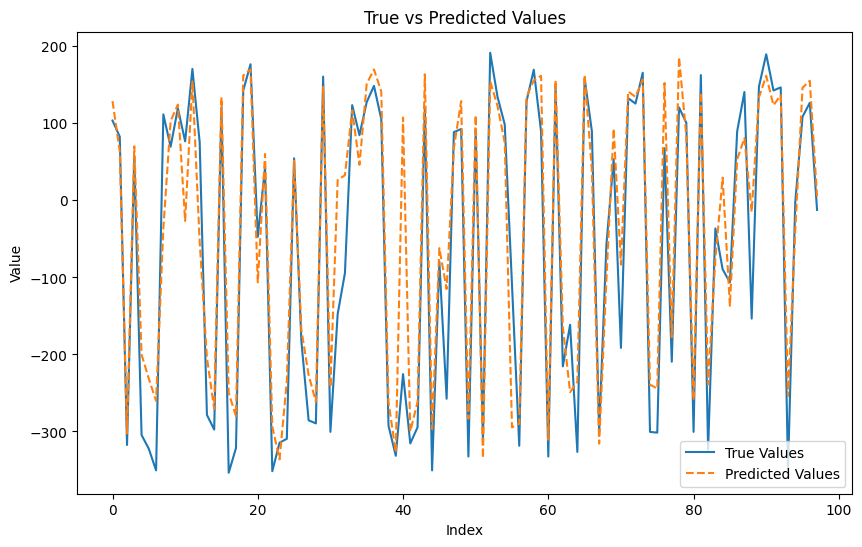

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


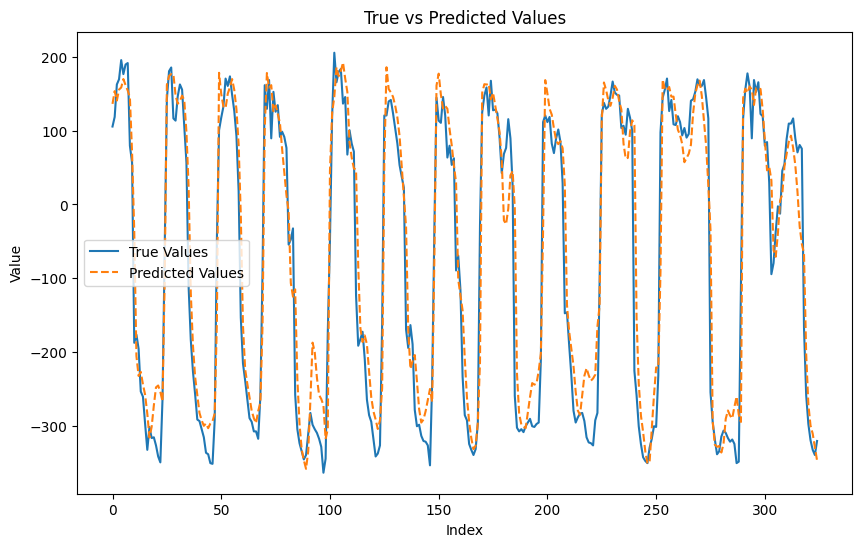

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


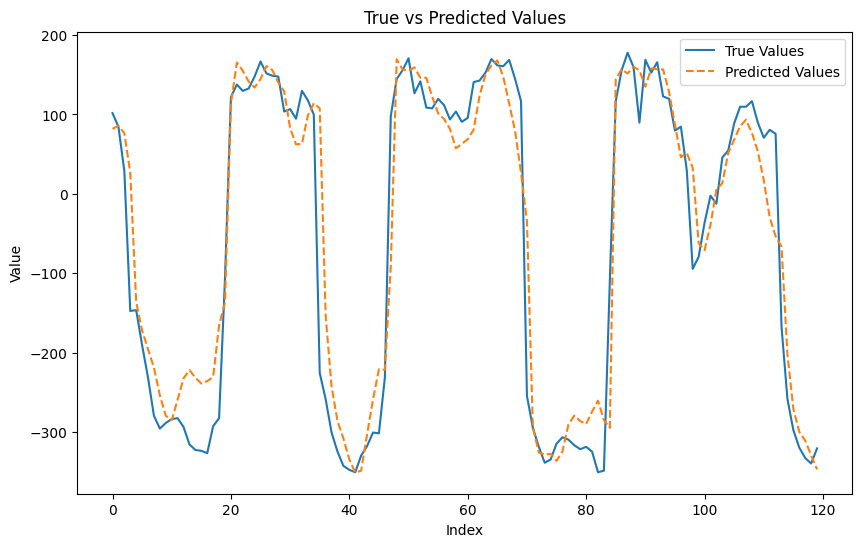

In [ ]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 807ms/step


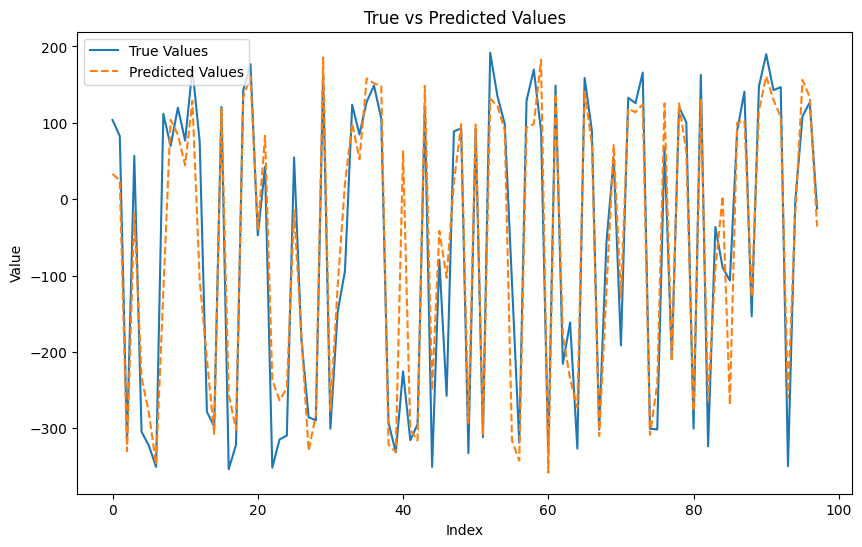

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


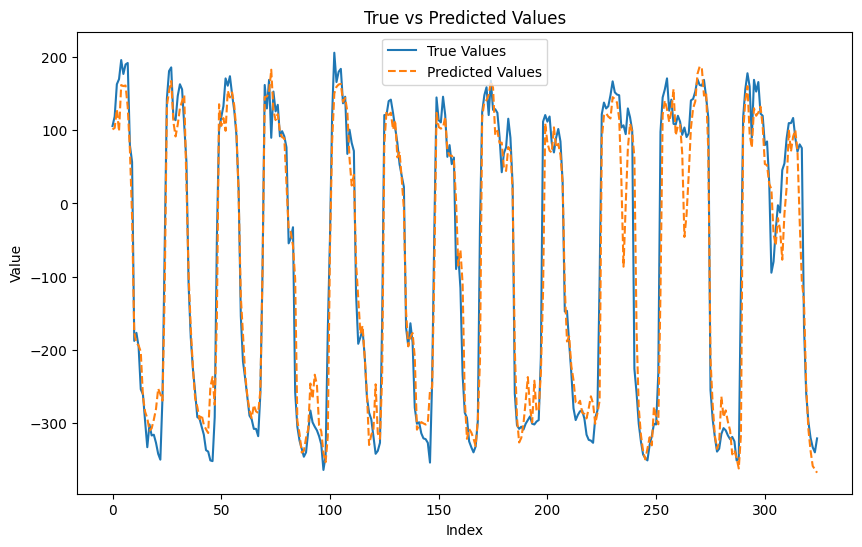

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


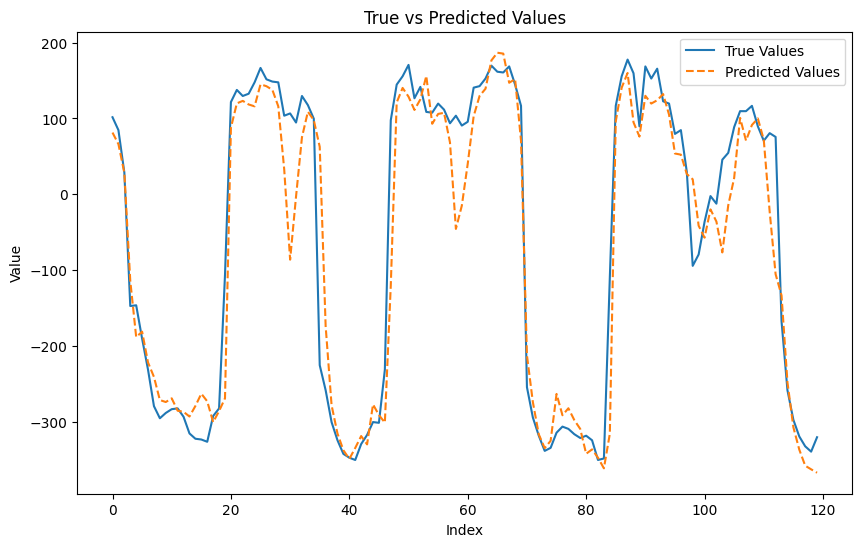

In [ ]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [ ]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [ ]:
# Dapatkan index datetime untuk data training dan testing
train_dates = data_df.index[:len(inverse_scaled_y_train)]
test_dates = data_df.index[len(inverse_scaled_y_train):len(inverse_scaled_y_train)+len(inverse_scaled_y_test)]

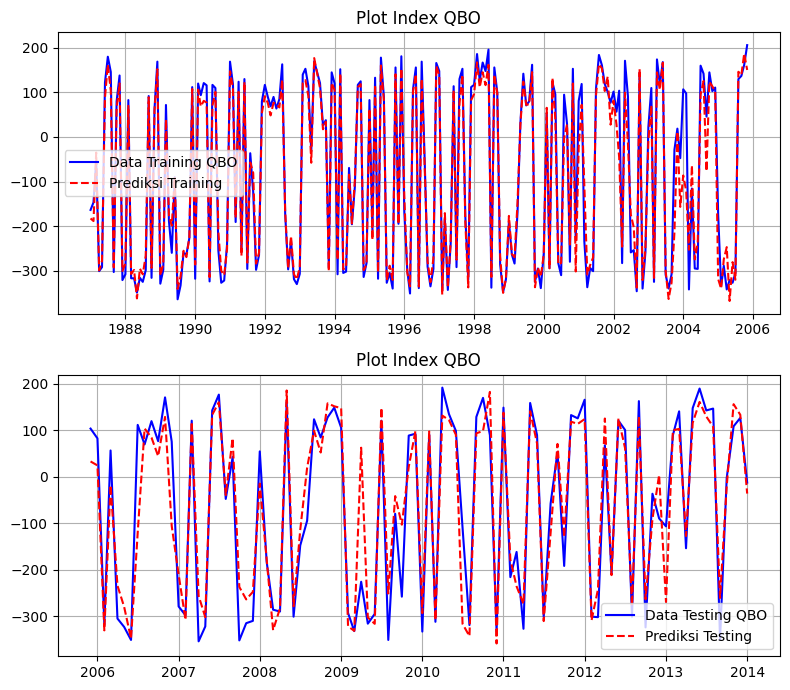

In [ ]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
# train_len = len(inverse_scaled_y_train)
# test_len = len(inverse_scaled_y_test)
# train_idx = np.arange(train_len)
# test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_dates, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_dates, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_dates, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_dates, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [ ]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [ ]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.08930593376719143
RMSE:  0.29884098408215604
R-squared:  0.9108131569353044
MAE:  0.21037770097096892
Log Likelihood:  -196192.64029775318
MAPE:  166.84422578519195


In [ ]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.06310461612967075
RMSE:  0.25120632183460423
R-squared:  0.9369795347520076
MAE:  0.15793784881122108
Log Likelihood:  -195465.83053000044
MAPE:  165.85518311320416


In [ ]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.12030394923197482
RMSE:  0.34684859698717946
R-squared:  0.8736781273860776
MAE:  0.24494321027050397
Log Likelihood:  -17240.07382707914
MAPE:  205.98715451546542


In [ ]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.11445599491547057
RMSE:  0.33831345659827156
R-squared:  0.8798186119249273
MAE:  0.23175532425020304
Log Likelihood:  -17323.44006727533
MAPE:  206.6519719970192


In [ ]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [ ]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  3621.6031483598676
RMSE:  60.17975696494518
R-squared:  0.9108131545313183
MAE:  42.36527053600334
Log Likelihood:  -588809.16663177
MAPE:  38.772335757462365


In [ ]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  2559.0670195821517
RMSE:  50.587221900220534
R-squared:  0.9369795348993898
MAE:  31.805079989172675
Log Likelihood:  -416147.04570539115
MAPE:  29.442289705619483


In [ ]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  4083.7835812929156
RMSE:  63.90448795892911
R-squared:  0.9012328173248574
MAE:  41.30577410414767
Log Likelihood:  -245137.28750155948
MAPE:  42.7756027556878


In [ ]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  3721.742783315022
RMSE:  61.00608808401848
R-squared:  0.9099888517517396
MAE:  37.37767156208015
Log Likelihood:  -223414.83962288586
MAPE:  38.512290827522996


In [ ]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  4878.658514469786
RMSE:  69.84739447158917
R-squared:  0.8736781260491306
MAE:  49.32597574531853
Log Likelihood:  -239144.32318527353
MAPE:  52.140218550866265
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  3078.9095107654452
RMSE:  55.48792220623732
R-squared:  0.9255002734584928
MAE:  39.36020750130224
Log Likelihood:  -349664.82851891546
MAPE:  33.00117952429356


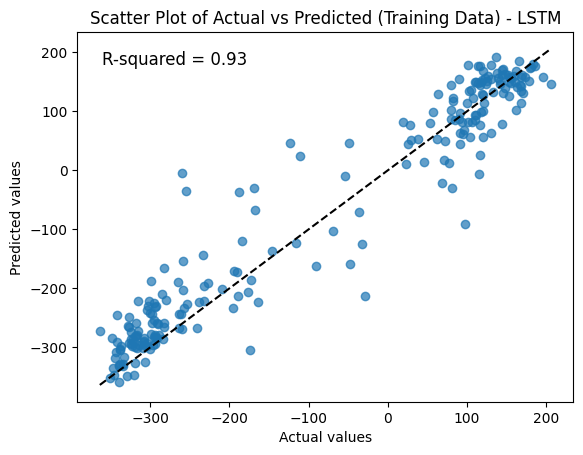

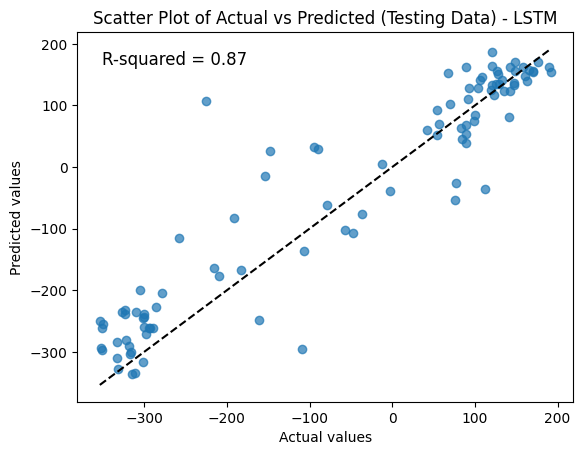

In [ ]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [ ]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  4641.507603516337
RMSE:  68.12861075580756
R-squared:  0.8798186147494452
MAE:  46.67023497507461
Log Likelihood:  -227523.92854855457
MAPE:  46.00617461818485
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  1660.0397911934338
RMSE:  40.74358589021631
R-squared:  0.9598323659531048
MAE:  25.387523940931867
Log Likelihood:  -188623.1153474921
MAPE:  22.29136038968601


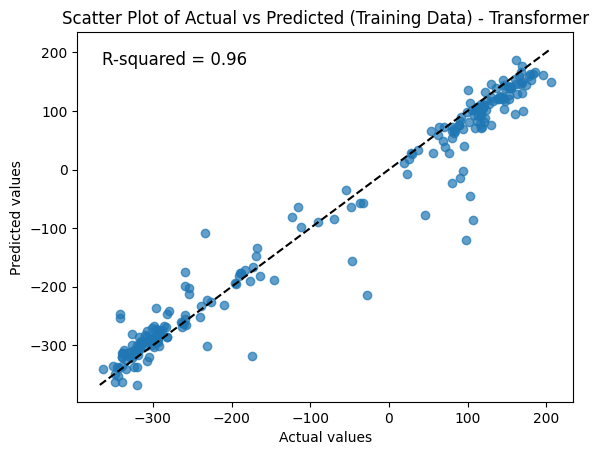

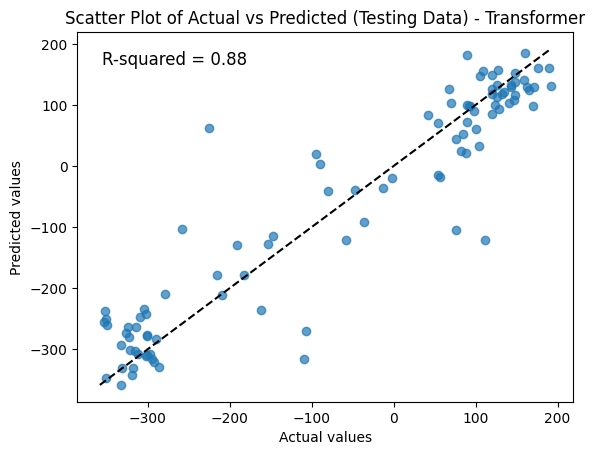

In [ ]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

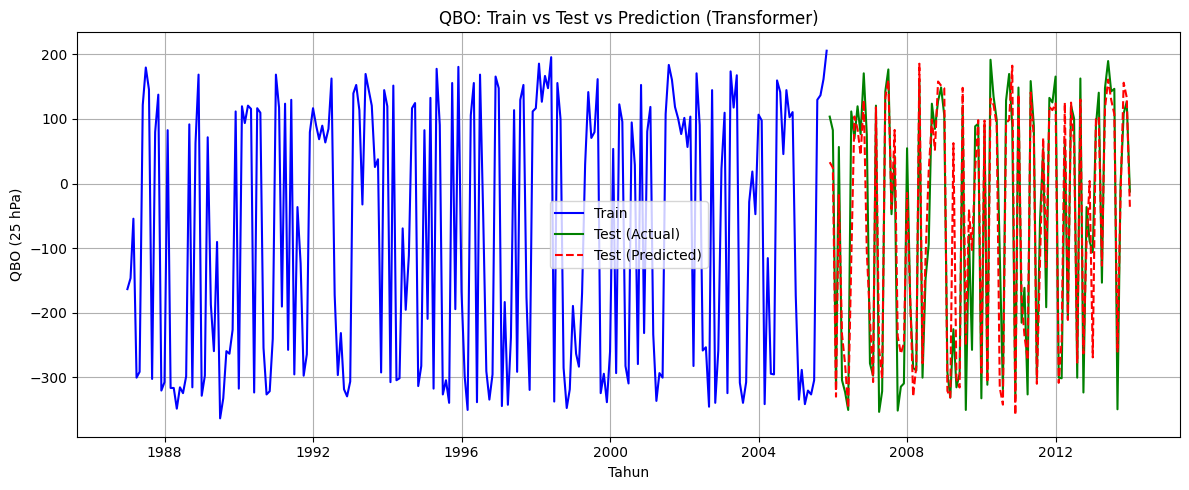

In [ ]:
plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_dates, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_dates, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_dates, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Tahun')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

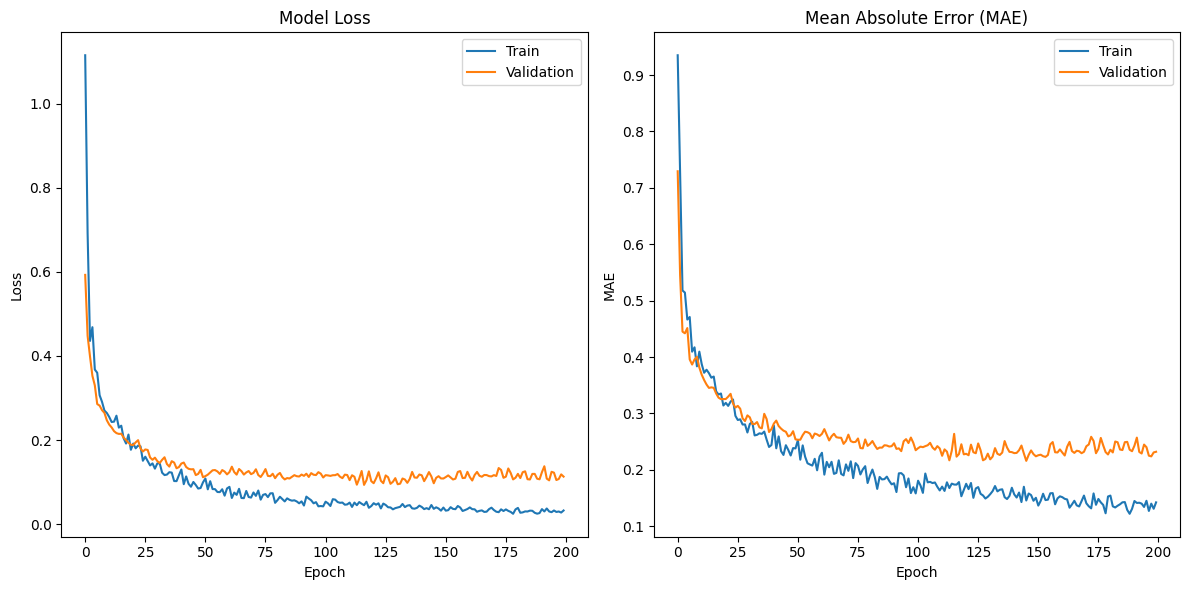

In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [ ]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

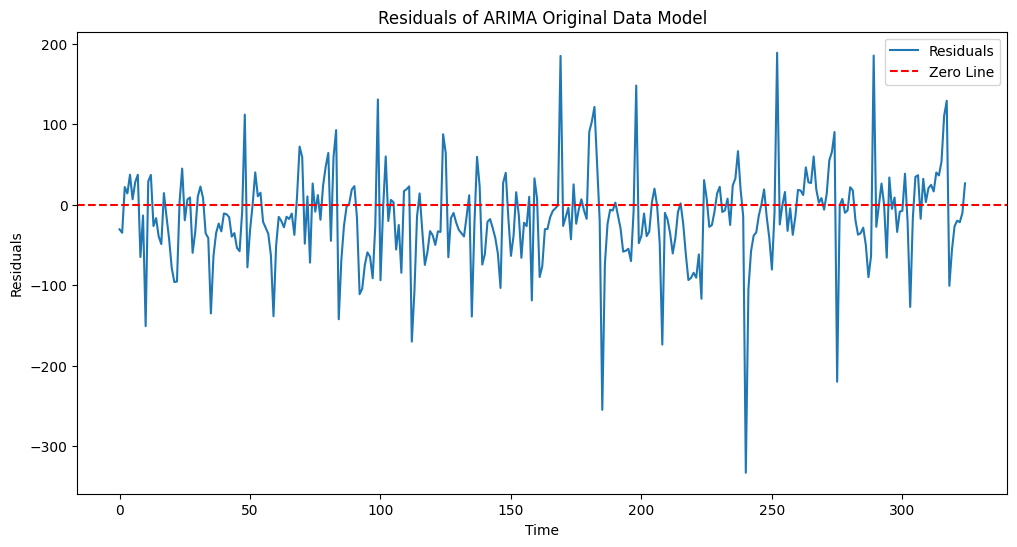

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

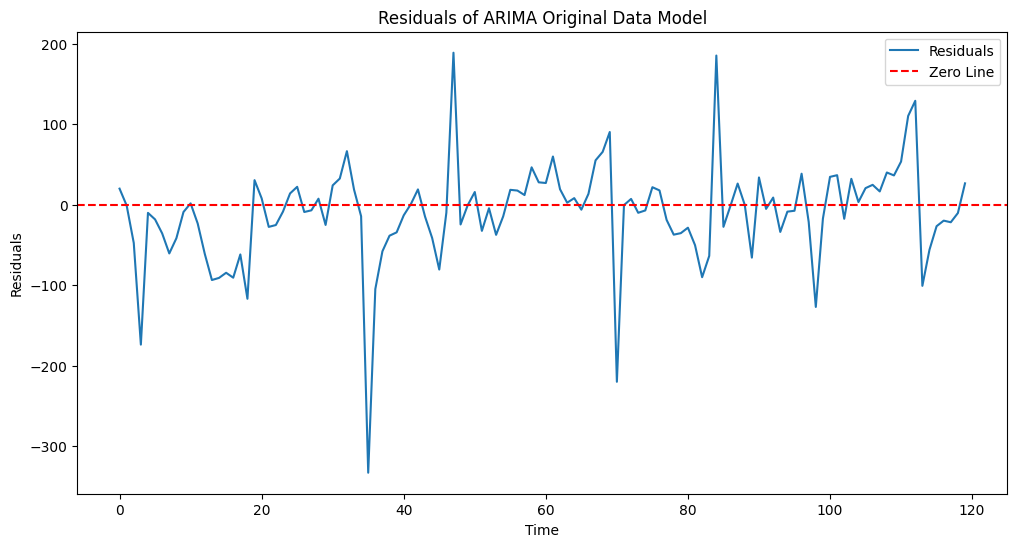

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

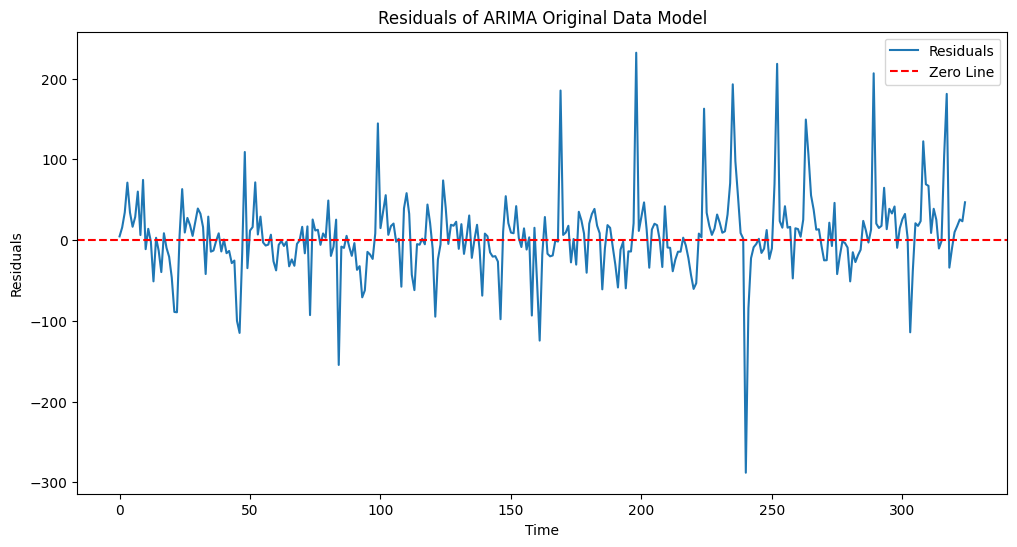

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

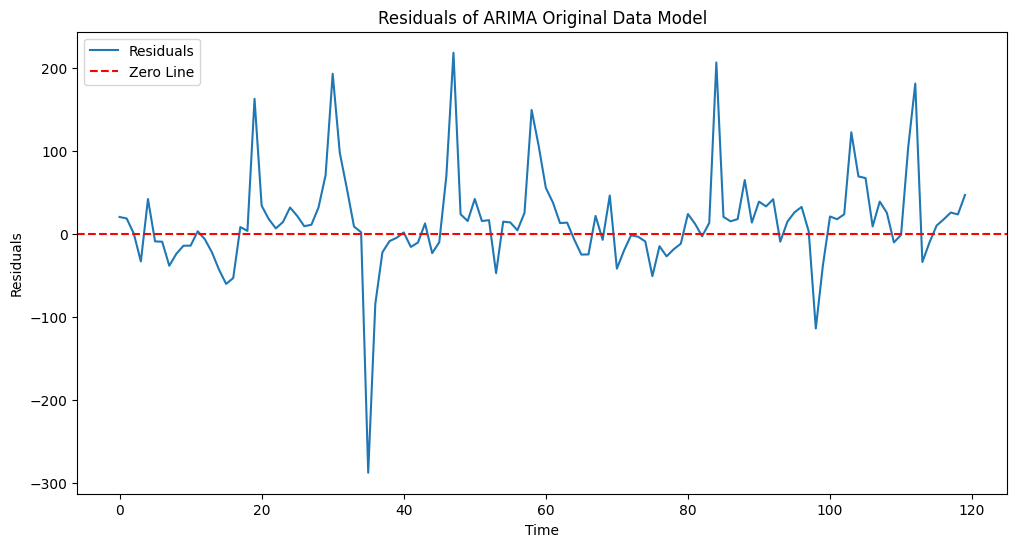

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9334645967771876
P-value: 7.027150370105317e-11
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

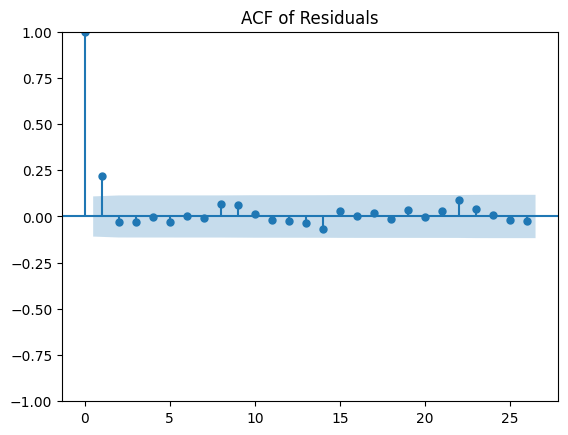

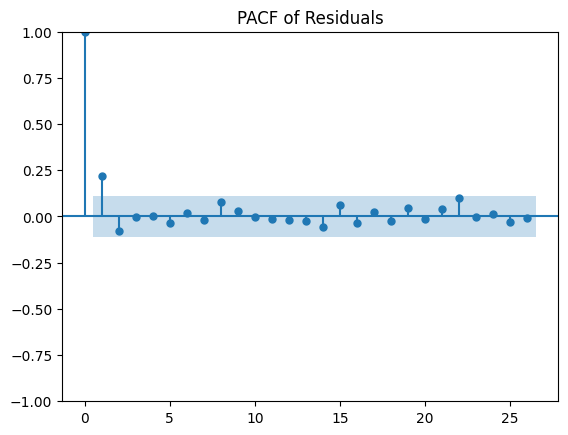

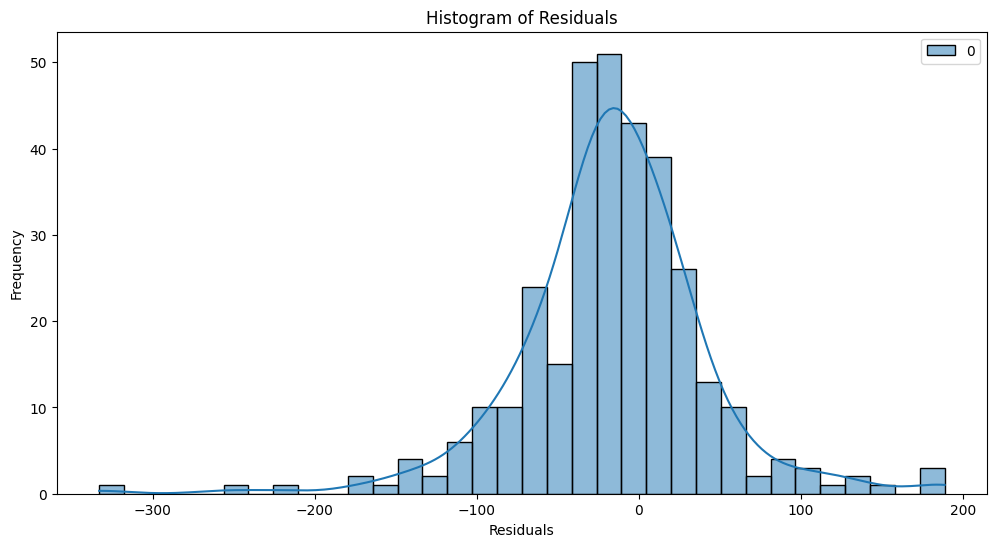

In [ ]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8804094349368833
P-value: 2.20750362834511e-08
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

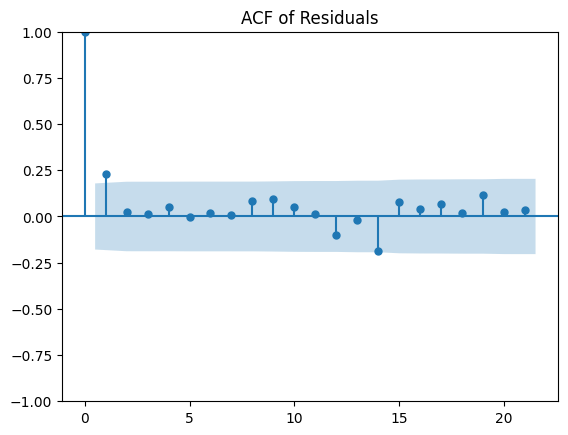

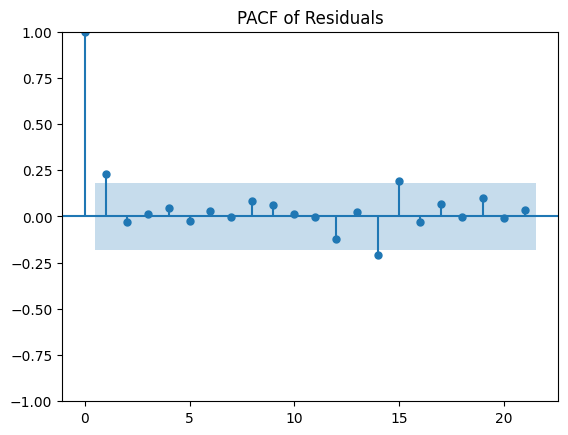

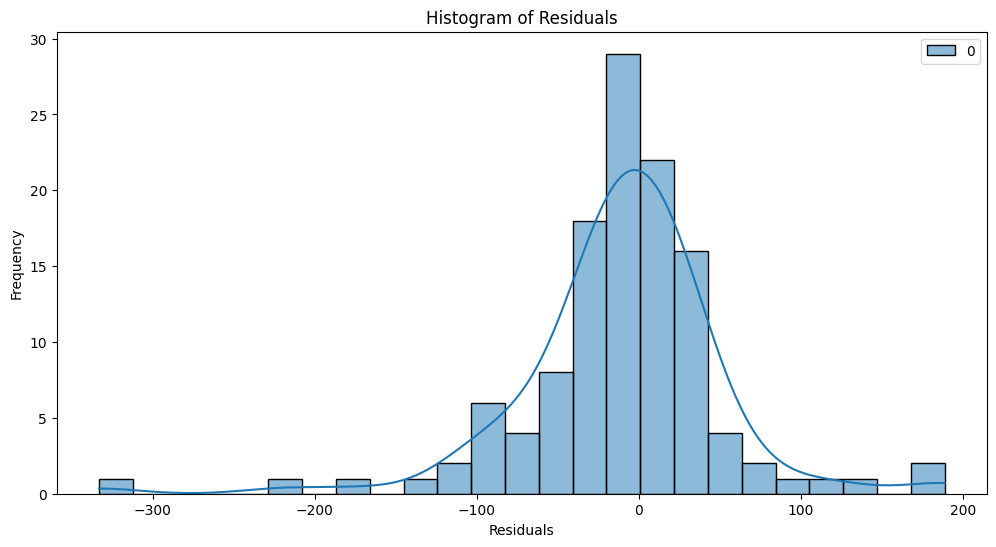

In [ ]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8604334329919742
P-value: 1.6625842360898397e-16
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

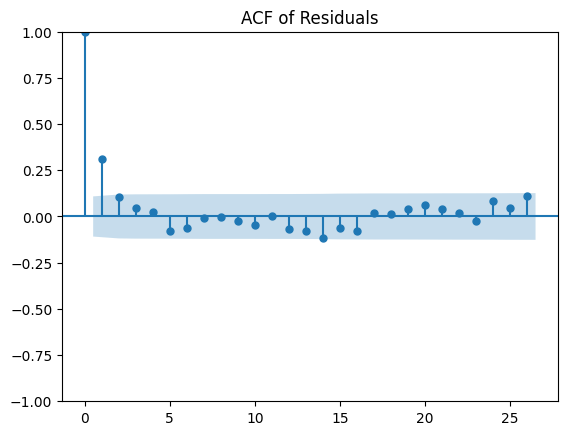

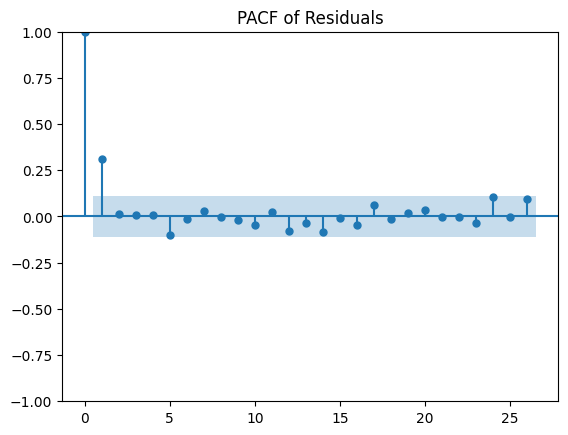

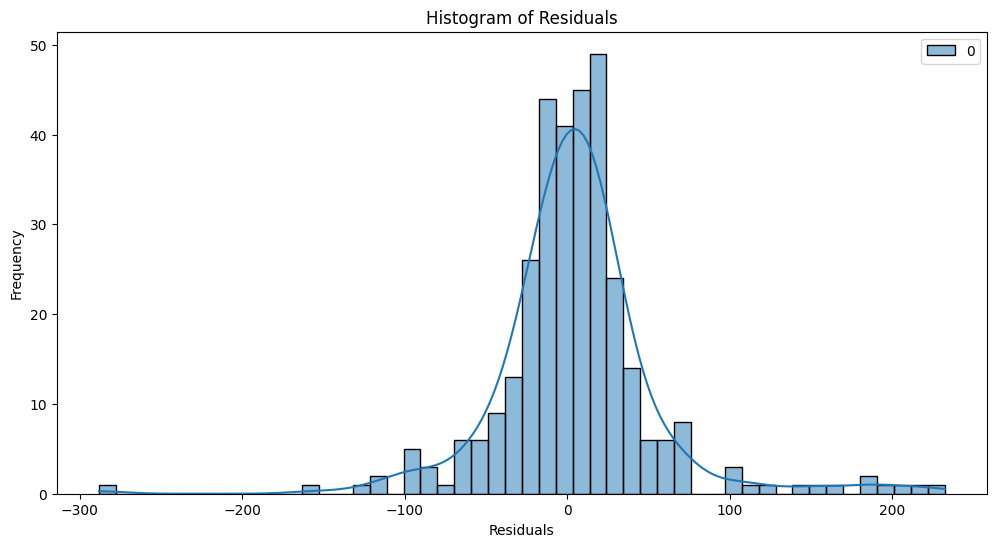

In [ ]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8278179474339455
P-value: 1.5876052655661796e-10
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

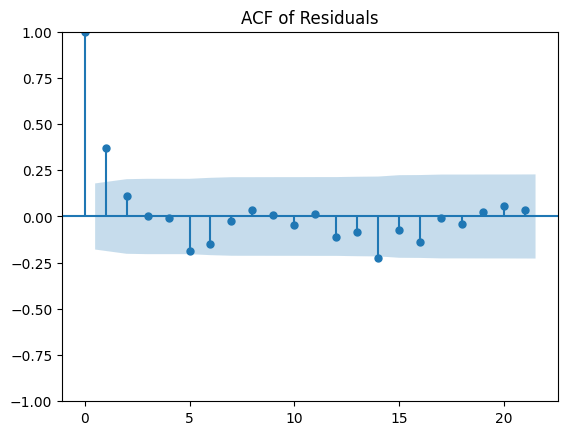

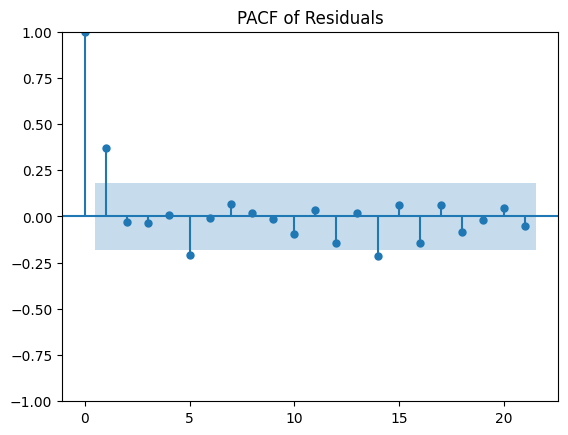

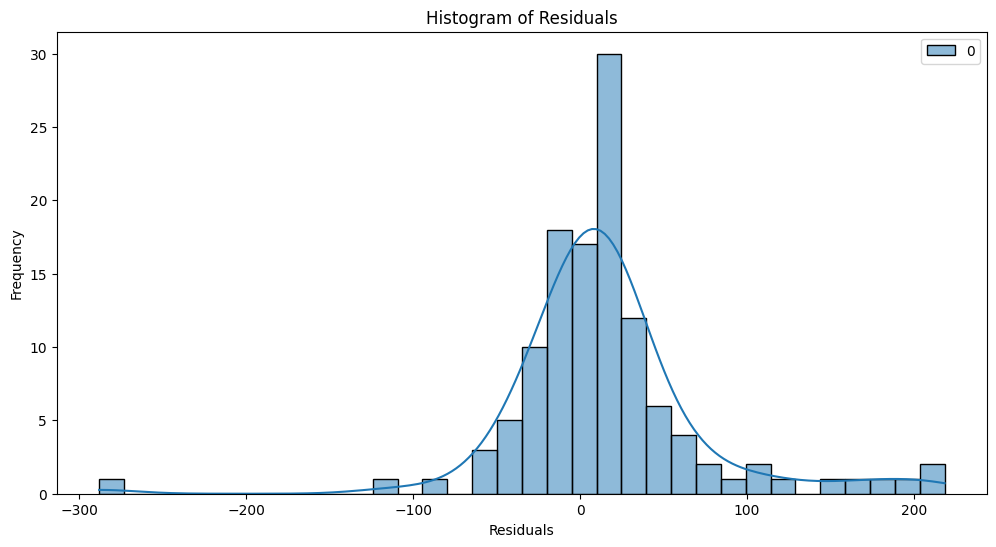

In [ ]:
residual_analysis(residuals_final2)